In [61]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict,Literal,Annotated
from langchain_core.messages import SystemMessage, HumanMessage
import os
# from pydantic import BaseModel,Field

In [62]:
load_dotenv()

True

In [63]:
generator_llm = ChatGoogleGenerativeAI(model = os.getenv('GEMINI_MODEL'), api_key = os.getenv('Google_API_KEY'))
evaluator_llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash', api_key = os.getenv('Google_API_KEY'))
optimizer_llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-pro', api_key = os.getenv('Google_API_KEY'))

In [64]:
# for structured output
from pydantic import BaseModel,Field

class TweetEvaluation(BaseModel):
    evaluation : Literal["approved","needs_improvement"] = Field(description = "Final evaluation result.")
    feedback : str = Field(description="feedback for the tweet")
    

In [65]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [66]:
# create a state 
class TweetState(TypedDict):
    topic : str # to store topic
    tweet : str # to store the generated tweet
    evaluation : Literal["approved","needs_improvement"]
    feedback : str # evaluator generates feedback
    iteration : int #inorder to how many iterations
    max_iterations : int # inorder to close our iteration
    response : str



In [67]:
def generate_tweet(state: TweetState):
    # prompt

    # prompt = f"""generate a tweet on this topic {state['topic']}."""

    messages = [
        SystemMessage(content = "You are a funny and clever Twitter/X influencer."),
        HumanMessage(content = f""" 
Write a short, original, and hilarious tweet on the topic: "{state['topic']}.

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- use simple, day to day english
""")
    ]
    # send to generator llm
    response = generator_llm.invoke(messages).content
    # return response
    return {'tweet': response}





In [68]:
def evaluate_tweet(state:TweetState):

    # prompt
    messages = [ 
        SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
        HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?  
2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness - Is it short, sharp, and scroll-stopping?  
4. Virality Potential - Would people retweet or share it?  
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

        # send to evaluator_llm
    response = structured_evaluator_llm.invoke(messages)
    return {'evaluation': response.evaluation, 'feedback': response.feedback}



In [69]:
def optimize_tweet(state : TweetState):
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration']+1
    return {'tweet' : response, 'iteration':iteration }




In [70]:
def route_evaluation(state: TweetState):
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iterations']:
        return "approved"
    else:
        return "needs_improvement"
    
    


In [71]:
#create object
graph = StateGraph(TweetState)

# create nodes
graph.add_node('generate_tweet',generate_tweet)
graph.add_node("evaluate_tweet",evaluate_tweet)
graph.add_node("optimize_tweet",optimize_tweet)

# create edges
graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet',route_evaluation,{'approved':END,'needs_improvement':'optimize_tweet'})
graph.add_edge('optimize_tweet','evaluate_tweet')

#compile
workflow = graph.compile()

intial_state = {
    "topic": "Indian Railways",
    "iteration" : 1,
    "max_iterations": 5
}
workflow.invoke(intial_state)



{'topic': 'Indian Railways',
 'tweet': 'Indian Railways: Where "seat confirmed" is just a suggestion. Like saying "diet starts tomorrow." We all know it\'s a lie. ',
 'evaluation': 'approved',
 'feedback': 'This tweet leverages a highly relatable scenario with Indian Railways and effectively pairs it with the universally understood "diet starts tomorrow" trope, creating a chuckle-worthy moment. It is concise, punchy, and its widespread relatability ensures strong virality potential. The format is impeccable, avoiding common pitfalls and delivering its humor directly without unnecessary fluff, making it a solid, shareable piece of content.',
 'iteration': 1,
 'max_iterations': 5}

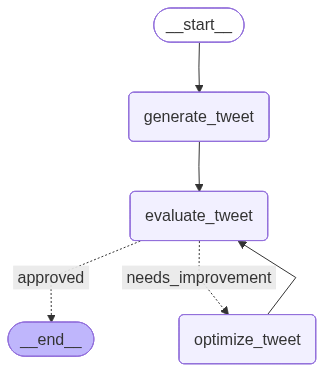

In [72]:
workflow